https://github.com/eriklindernoren/PyTorch-YOLOv3

In [1]:
import os
import cv2
import torch
import numpy as np
from yolov3.models import Darknet
from yolov3.utils.utils import non_max_suppression
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
CUDA_VISIBLE_DEVICES=4

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    torch.cuda.current_device()
else:
    device = torch.device('cpu')

In [4]:
# set up model
model = Darknet('yolov3/config/yolov3.cfg', img_size=416).float().to(device)
model.load_darknet_weights('yolov3/weights/yolov3.weights')
model.eval();  # model.train(False)

In [5]:
# prepare images
def load_img(img):
    img = cv2.imread(img) / 255.0
    img = img[:,:,::-1]
    return img

def img2tensor(img):
    h, w, _ = img.shape
    img = np.pad(img, 
                ([max((w-h)//2, 0), max(w-h-(w-h)//2, 0)],
                 [max((h-w)//2, 0), max(h-w-(h-w)//2, 0)],
                 [0, 0]), 
                'constant', 
                constant_values = (0, 0))
    img = cv2.resize(img, (416, 416))
    img = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)
    return img.float(), [h, w]

imgs = ['imgs/000000005239.jpg', 'imgs/000000520495.jpg','imgs/000000002343.jpg','imgs/000000001950.jpg']
imgs = [load_img(x) for x in imgs]
input_imgs = []
shapes = []
for img in imgs:
    input_tensor, shape = img2tensor(img)
    input_imgs.append(input_tensor)
    shapes.append(shape)

input_imgs = torch.cat(input_imgs, dim=0)
print("Input img shape: {}".format(input_imgs.shape))

Input img shape: torch.Size([4, 3, 416, 416])


In [6]:
# Get detections
detections = model(input_imgs.to(device))
detections = non_max_suppression(detections, conf_thres=0.25, nms_thres=0.5)
print(len(detections))
# (x1, y1, x2, y2, object_conf, class_score, class_pred)
torch.set_printoptions(precision=2, sci_mode=False)
print("detections_0:\n{}".format(detections[0]))
print("detections_2:\n{}".format(detections[2]))
# classes
with open('yolov3/config/coco.names', 'r') as f:
    lines = f.readlines()
class_names = [x.strip() for x in lines]
print("\nclass_names: \n{}".format(class_names))

4
detections_0:
tensor([[ 94.81, 175.82, 198.97, 286.45,   0.98,   0.99,  23.00],
        [295.04, 195.68, 345.07, 269.30,   0.97,   1.00,  23.00],
        [144.90, 189.04, 236.96, 301.24,   0.97,   1.00,  23.00],
        [ 46.71, 162.21, 149.39, 276.41,   0.99,   0.97,  23.00],
        [213.82, 224.24, 280.68, 300.53,   0.74,   1.00,  23.00]])
detections_2:
tensor([[  200.85,   282.77,   226.01,   339.28,     0.99,     1.00,     0.00],
        [  244.06,   303.35,   282.42,   399.38,     0.99,     1.00,     0.00],
        [  179.65,   276.92,   202.24,   333.63,     0.99,     1.00,     0.00],
        [  234.19,   278.61,   257.11,   342.67,     0.99,     1.00,     0.00],
        [  127.30,   277.63,   150.17,   338.95,     0.99,     1.00,     0.00],
        [  283.76,   279.90,   303.04,   329.77,     0.96,     1.00,     0.00],
        [  147.61,   286.92,   163.99,   335.45,     0.96,     1.00,     0.00],
        [  266.86,   277.95,   282.01,   321.59,     0.89,     1.00,     0.00],

In [7]:
# Process detections
detections = [x.detach().cpu().numpy() for x in detections]
for ind, det in enumerate(detections):
    h, w = shapes[ind]
    scale = max(shape) / 416.0
    det[:,0:4] *= scale
    det[:,2:4] -= det[:,0:2]
    det[:,0:2] -= np.asarray([max((h-w)//2, 0), max((w-h)//2, 0)])

In [23]:
shapes

[[426, 640], [427, 640], [640, 443], [426, 640]]

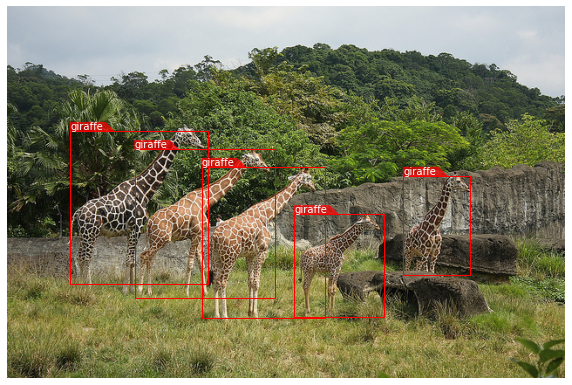

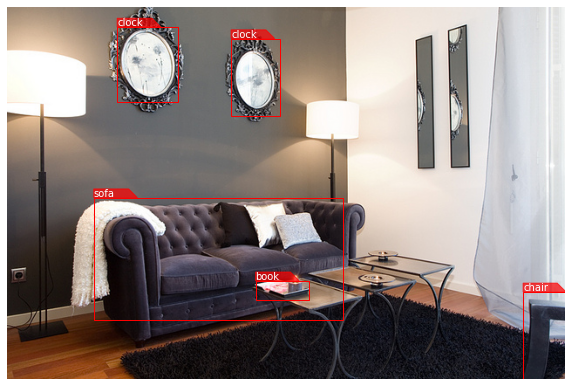

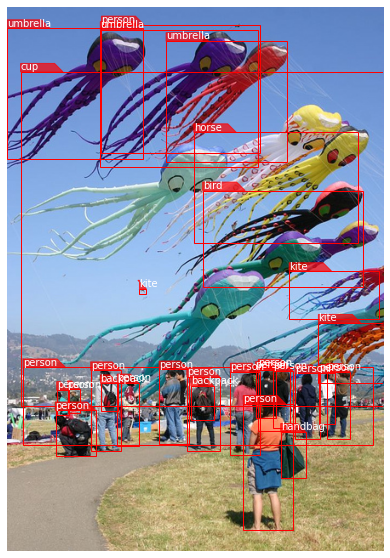

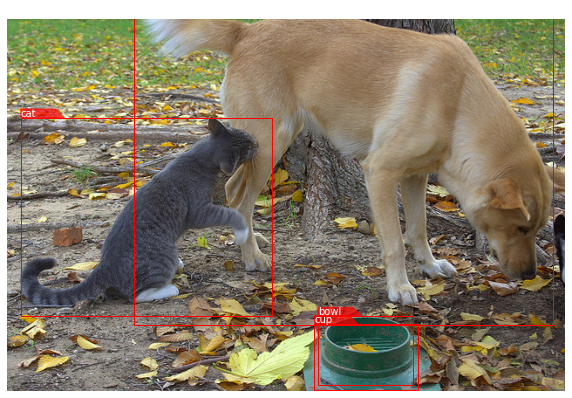

In [8]:
# Visialization
for ind, img in enumerate(imgs):

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    ax.imshow(img)
    det = detections[ind]
    for j in range(det.shape[0]):
        # rect = plt.Rectangle((det[0:2]), det[2], det[3])
        rect = plt.Rectangle((det[j][0], det[j][1]), 
                              det[j][2], det[j][3], 
                              linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)#以坐标轴为参考系（原点在左下角），添加形状
        poly = patches.Polygon([[det[j][0], det[j][1]], 
                                [det[j][0], det[j][1]-10], 
                                [det[j][0]+min(50, det[j][2])-10, det[j][1]-10],
                                [det[j][0]+min(50, det[j][2]), det[j][1]]],
                               alpha=0.7, color='red')
        ax.add_patch(poly)
        ax.text(det[j][0], det[j][1]-2, class_names[int(det[j][-1])], color='white', fontsize=10)
        ax.axis('off')

In [10]:
import cv2
import numpy as np
from yolov3.models import Darknet
from yolov3.utils.utils import non_max_suppression

# set up model
model = Darknet('yolov3/config/yolov3.cfg', img_size=416).float().to(device)
model.load_darknet_weights('yolov3/weights/yolov3.weights')
model.eval();  # model.train(False)

# import ipywidgets as widgets
# from IPython.display import display

# imgbox = widgets.Image(format='jpg', height=540, width=720)
# display(imgbox)

cap = cv2.VideoCapture('test.mp4')
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
scale = max(w, h) / 416.0

colors = {0:(0,0,255), 1:(0,255,0), 2:(255,0,0), 9:(255,0,255)}

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    img = frame[:,:,::-1] / 255.0
    img = img2tensor(img)[0]
    detections = model(img.to(device))
    detections = non_max_suppression(detections, conf_thres=0.3, nms_thres=0.5)
    det = [x.detach().cpu().numpy() for x in detections][0]
    det[:,0:4] *= scale
    det[:,0:2] -= np.asarray([max((h-w)//2, 0), max((w-h)//2, 0)])
    det[:,2:4] -= np.asarray([max((h-w)//2, 0), max((w-h)//2, 0)])
    for j in range(det.shape[0]):
        cv2.rectangle(frame, (det[j,0], det[j,1]), (det[j,2], det[j,3]), 
                      color=colors[int(det[j][-1])] if int(det[j][-1]) in colors else (0,255,255),
                      thickness=2)

    imgbox.value = cv2.imencode('.jpg', frame)[1].tobytes()

Image(value=b'', format='jpg', height='540', width='720')

<ipython-input-10-60ffc0dac374>:30: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(frame, (det[j,0], det[j,1]), (det[j,2], det[j,3]),
